In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools

print(f'Using 21cmFAST version {p21c.__version__}')
p21c.config['direc'] = '/scratch/submit/ctp/yitians/21cmFAST-cache'

Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230216


/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [4]:
from dm21cm.common import get_circle_seq_at

## 1. Test run

In [5]:
cache_tools.clear_cache()

2023-02-18 11:30:46,366 | INFO | Removing IonizedBox_2323daf3fe9bdfb546bf72cf9041a1de_r54321.h5
2023-02-18 11:30:46,373 | INFO | Removing PerturbedField_efd2cbfb11c49cdc787c44bd838c08e3_r54321.h5
2023-02-18 11:30:46,381 | INFO | Removing TsBox_14c5bb5c22bee24e6d397d21b15a5c4d_r54321.h5
2023-02-18 11:30:46,390 | INFO | Removing TsBox_c5dfb6e4d191d1b5b0d6bfc1b839c917_r54321.h5
2023-02-18 11:30:46,398 | INFO | Removing IonizedBox_7130b77ef05a0ecf14e41c42d7b854a3_r54321.h5
2023-02-18 11:30:46,407 | INFO | Removing TsBox_0df99e8163012efb3503637ea3f74107_r54321.h5
2023-02-18 11:30:46,415 | INFO | Removing TsBox_2cf1ff4883ca9c4d80ea3c0a7c8d2683_r54321.h5
2023-02-18 11:30:46,423 | INFO | Removing IonizedBox_77d35446d963c1c742b04f31cecfd9b9_r54321.h5
2023-02-18 11:30:46,429 | INFO | Removing PerturbedField_8d9e78311b48080cac226759b3034319_r54321.h5
2023-02-18 11:30:46,434 | INFO | Removing PerturbedField_4d0994024c25cc76e867d8a59272b882_r54321.h5
2023-02-18 11:30:46,439 | INFO | Removing Pertur

In [6]:
# initialize
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 50, "BOX_LEN": 50},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321, write=True
)

# redshift
rs_arr = 35*1.05**(-np.arange(10))

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


In [7]:
Tk_box_arr = []

for i_rs, rs in enumerate(rs_arr):
    
    print(f'i_rs={i_rs} rs={rs:.3f}')
    
    # input
    input_heating = p21c.input_heating(redshift=rs, init_boxes=initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=rs, init_boxes=initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=rs, init_boxes=initial_conditions, write=False)

    input_heating.input_heating += get_circle_seq_at(50, 3, i_rs)
    input_ionization.input_ionization += get_circle_seq_at(50, 5, 9-i_rs) * 1e-3
    
    # perturbed_field to control redshift
    perturbed_field = p21c.perturb_field(redshift=rs, init_boxes=initial_conditions)
    
    # calculate spin temperature
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_rs==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        write=True
    )
    Tk_box_arr.append(spin_temp.Tk_box)

i_rs=0 rs=35.000


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=1 rs=33.333


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=2 rs=31.746


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=3 rs=30.234


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=4 rs=28.795


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=5 rs=27.423


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=6 rs=26.118


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=7 rs=24.874


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=8 rs=23.689


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_rs=9 rs=22.561


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation


### view result

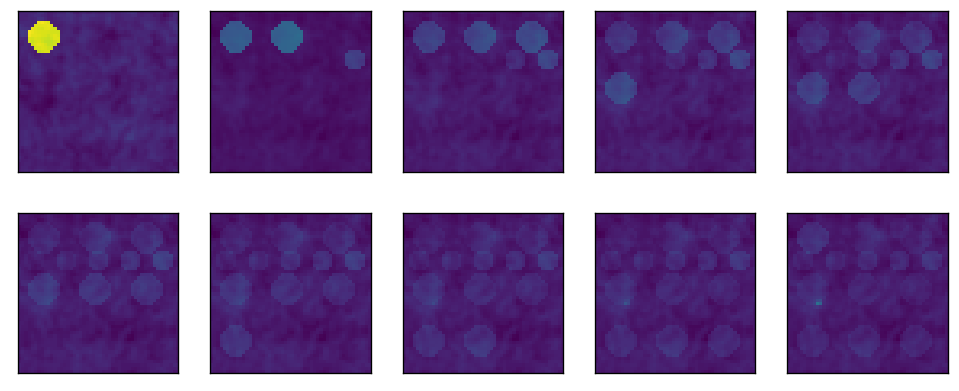

In [9]:
vmax = np.max(Tk_box_arr)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(Tk_box_arr[i*5+j][25], vmax=vmax)
        axs[i,j].set(xticks=[], yticks=[])

In [10]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
)

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The followin

Just Before Box Evaluation


KeyboardInterrupt: 

## Archive

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title='input_heating', xticks=[], yticks=[])
axs[1].set(title='input_ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')